In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
data_dir = '/Users/akhireddy/Downloads/AAI/AI-Project/Dataset-1/'
full_data = datasets.ImageFolder(data_dir, transform=train_transforms)

In [5]:
dataset_size = len(full_data)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_data, val_data = random_split(full_data, [train_size, val_size])

# Test dataset creation
test_data = datasets.ImageFolder(data_dir, transform=test_transforms)

print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}, Testing samples: {len(test_data)}")

Training samples: 4733, Validation samples: 1184, Testing samples: 5917


In [6]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=5):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, running_corrects, total_samples = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

        epoch_train_loss = running_loss / total_samples
        epoch_train_acc = running_corrects.double() / total_samples
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc.item())

        model.eval()
        val_loss, val_corrects, val_samples = 0.0, 0, 0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss_batch = criterion(val_outputs, val_labels)
                _, val_preds = torch.max(val_outputs, 1)

                val_loss += val_loss_batch.item() * val_inputs.size(0)
                val_corrects += torch.sum(val_preds == val_labels.data)
                val_samples += val_labels.size(0)

        epoch_val_loss = val_loss / val_samples
        epoch_val_acc = val_corrects.double() / val_samples
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc.item())

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc*100:.2f}%, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc*100:.2f}%")

        scheduler.step()

    return train_losses, val_losses, train_accuracies, val_accuracies

In [7]:
batch_sizes = [16, 32, 64]
learning_rates = [0.01, 0.001, 0.0001]
n_epochs = 5

best_acc = 0.0
best_params = None

for batch_size, lr in product(batch_sizes, learning_rates):
    print(f"Testing batch size {batch_size} and learning rate {lr}")

    # DataLoader creation
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)

    # Load and Customize VGG16
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    for param in model.features.parameters():
        param.requires_grad = False
    
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(test_data.classes))
    model = model.to(device)

    # Loss, Optimizer, and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # Train and Validate
    _, _, _, val_accuracies = train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=n_epochs)
    final_val_acc = val_accuracies[-1]

    if final_val_acc > best_acc:
        best_acc = final_val_acc
        best_params = (batch_size, lr)

print(f"Best Parameters: Batch Size = {best_params[0]}, Learning Rate = {best_params[1]} with Validation Accuracy: {best_acc*100:.2f}%")

Testing batch size 16 and learning rate 0.01
Epoch 1/5 - Train Loss: 61.7663, Train Acc: 69.68%, Val Loss: 6.8002, Val Acc: 78.38%
Epoch 2/5 - Train Loss: 10.5410, Train Acc: 78.09%, Val Loss: 1.5676, Val Acc: 79.14%
Epoch 3/5 - Train Loss: 4.7270, Train Acc: 79.08%, Val Loss: 0.6776, Val Acc: 79.56%
Epoch 4/5 - Train Loss: 1.4567, Train Acc: 79.82%, Val Loss: 1.0284, Val Acc: 79.56%
Epoch 5/5 - Train Loss: 1.1669, Train Acc: 79.91%, Val Loss: 0.9035, Val Acc: 79.65%
Testing batch size 16 and learning rate 0.001
Epoch 1/5 - Train Loss: 0.8967, Train Acc: 72.30%, Val Loss: 0.5619, Val Acc: 75.42%
Epoch 2/5 - Train Loss: 0.8262, Train Acc: 71.22%, Val Loss: 0.5774, Val Acc: 79.31%
Epoch 3/5 - Train Loss: 0.6612, Train Acc: 74.43%, Val Loss: 0.5251, Val Acc: 79.73%
Epoch 4/5 - Train Loss: 0.5752, Train Acc: 78.09%, Val Loss: 0.5326, Val Acc: 79.81%
Epoch 5/5 - Train Loss: 0.5252, Train Acc: 79.89%, Val Loss: 0.5536, Val Acc: 79.81%
Testing batch size 16 and learning rate 0.0001
Epoch 1/5 

In [8]:
best_batch_size, best_lr = best_params
train_loader = DataLoader(train_data, batch_size=best_batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=best_batch_size)
test_loader = DataLoader(test_data, batch_size=best_batch_size)

model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
for param in model.features.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(test_data.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=best_lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [9]:
train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=n_epochs)

# Evaluate on Test Data
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")

Epoch 1/5 - Train Loss: 0.9913, Train Acc: 71.73%, Val Loss: 0.8348, Val Acc: 78.55%
Epoch 2/5 - Train Loss: 0.8030, Train Acc: 72.17%, Val Loss: 0.7095, Val Acc: 79.81%
Epoch 3/5 - Train Loss: 0.6591, Train Acc: 75.05%, Val Loss: 0.5660, Val Acc: 79.81%
Epoch 4/5 - Train Loss: 0.5631, Train Acc: 78.72%, Val Loss: 0.5397, Val Acc: 79.81%
Epoch 5/5 - Train Loss: 0.5298, Train Acc: 79.67%, Val Loss: 0.5366, Val Acc: 79.81%
Test Accuracy: 80.02%
Precision: 84.02%
Recall: 80.02%
F1 Score: 71.18%


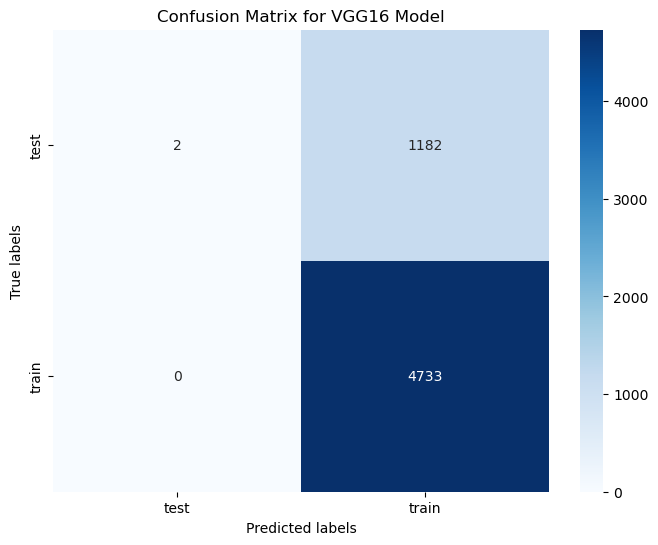

In [10]:
conf_matrix = confusion_matrix(all_labels, all_preds)
class_names = test_loader.dataset.classes

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for VGG16 Model')
plt.show()
